# AMS 595 Project 5

## 1. Page Rank Algorithm

### Importing Libraries and Setting up Array M

In [1]:
# Importing libraries
import numpy as np
from scipy.linalg import eig

In [3]:
# Setting up array
M = np.array([
    [0, 0, 1/2, 0],
    [1/3, 0, 0, 1/2],
    [1/3, 1/2, 0, 1/2],
    [1/3, 1/2, 1/2, 0]
])

In [5]:
print(M)

[[0.         0.         0.5        0.        ]
 [0.33333333 0.         0.         0.5       ]
 [0.33333333 0.5        0.         0.5       ]
 [0.33333333 0.5        0.5        0.        ]]


### Finding Index of the Dominant Eigenvalue (Closest to 1) 

In [8]:
# Computing eigenvalues and eigenvectors
eigenval, eigenvec = eig(M)

In [10]:
# Finding index of eigenvalue closest to 1
index = np.argmax(np.real(eigenval))
pagerank = np.real(eigenvec[:, index])

In [12]:
# Normalization
pagerank = pagerank / np.sum(pagerank)
print(pagerank) # displaying the dominant eigenvector

[0.15789474 0.21052632 0.31578947 0.31578947]


### Creating Intial Rank Vector v and Iterating Until Convergence

In [15]:
# Starting with initial rank vector v (of ones)
v = np.ones(4) / 4
epsilon = 1e-6

In [17]:
# Iterating until convergence
while True:
    v_n = M @ v
    if np.linalg.norm(v_n - v) < epsilon: # if difference between consecutive rank vectors is small
        break
    v = v_n # setting current vector to the next consecutive vector

pagerank_it = v_n / np.sum(v_n) # normalizing
print(pagerank_it) # displaying the dominant eigenvector

[0.15789468 0.21052625 0.31578954 0.31578954]


The values of the eigenvector represent page importance. Each value represents the long term probability of being on page i (after several random clicks). So, a higher value indicates that a user is more likely to be on that page in the steady state. Based on the final PageRank scores, **page 3** and **page 4** are ranked the highest (equal rank) as the eigenvector shows equal probability for both. This may have to do with the symmetry involved in the patterns of page 3 and page 4 (each page has an 0.5 probability of linking to the other and to the same other pages).

## 2. Dimensionality Reduction via PCA

### Importing Libraries and Loading Data

In [22]:
# Importing libraries
import pandas as pd
from scipy.linalg import eigh
import matplotlib.pyplot as plt
#Loading dataset
data = pd.read_csv('data.csv')

### Computing the Covariance Matrix

In [24]:
# Computing covariance matrix
cov_mat = np.cov(data, rowvar=False)
print(cov_mat)

[[1.02608749 0.11769063]
 [0.11769063 1.08134929]]


### Eigenvalue Decomposition

In [28]:
eigenval, eigenvec = eigh(cov_mat)

### Identifying Principal Components

In [31]:
# Sorting eigenvalues and eigenvectors in descending order
eigenval = eigenval[::-1]
eigenvec = eigenvec[:, ::-1]
print("Eigenvalues (variance explained):", eigenval)
print("Eigenvectors (principal components):\n", eigenvec)

Eigenvalues (variance explained): [1.17460905 0.93282774]
Eigenvectors (principal components):
 [[ 0.62106317 -0.78376051]
 [ 0.78376051  0.62106317]]


The first principal component is the eigenvector [0.621, 0.784]. The second principal component is [0.784,0.621]. They are orthogonal to each other. The eigenvalues represent the amount of variance explained by each principal component. After dividing each value by the total variance, we can say that the **first principal component** explains about **56%** of the variance, while the **second principal component** explains about **44%** of the variance. 

### Reducing the Dataset to 1D

In [35]:
# Taking first principal component
pc1 = eigenvec[:, 0]
# Projecting data onto pc1
z = data @ pc1

### Plotting Original Data and 1D Projection

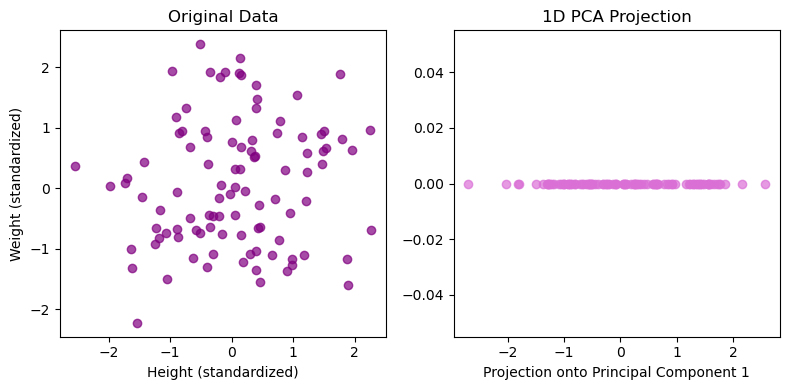

In [38]:
# Plotting original data
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(data["Height"], data["Weight"], alpha=0.7, color = 'purple')
plt.xlabel('Height (standardized)')
plt.ylabel('Weight (standardized)')
plt.title('Original Data')

# Plotting 1D projection along PC1
plt.subplot(1,2,2)
plt.scatter(z, np.zeros_like(z), alpha=0.7, color = 'orchid')
plt.xlabel('Projection onto Principal Component 1')
plt.title('1D PCA Projection')

plt.tight_layout()
plt.show()

As we can tell by both of these plots, height and weight appear to be correlated.

## 3. Linear Regression via Least Squares

### Importing Libraries

In [43]:
from scipy.linalg import lstsq

### Data

In [46]:
# Predictor matrix: adding ones columns for intercept
X = np.array([
    [1, 2100, 3, 20],
    [1, 2500, 4, 15],
    [1, 1800, 2, 30],
    [1, 2200, 3, 25]
], dtype=float)

In [48]:
# Target vector
y = np.array([460, 540, 330, 400], dtype=float)

### Solving Least-Squares Problem Xβ = y

In [51]:
beta, residuals, rank, s = np.linalg.lstsq(X, y, rcond = None)

In [53]:
print("Coefficients (β):", beta)

Coefficients (β): [ 5.61935591e+02  4.77822046e-01 -2.23911023e+02 -2.15564409e+01]


As we can tell by the coefficients above, square footage has a positive impact on house price, while number of bedrooms and age has a negative impact on house price. However, the interpretation of these coefficients might be innacurate due to scaling issues (specifically, the number of bedrooms variable) and small sample size.

### Predicting Prices of a New House

In [57]:
# New house predictors
new_house = np.array([1,2400, 3, 20])
# Predicting new house price
pred_price = new_house @ beta
print("Predicted price (in $1000s):", pred_price)


Predicted price (in $1000s): 605.8466138201965


The price of this house would be approximately $605,846.61. 

### Discussing the Role of the Least Squares Method in this Prediction Task

In general, using scipy's 'lstsq' is a safer/more flexible option than directly solving with scipy's 'solve.' lstsq provides a best linear approximation to the data, and may be used even if the predictor matrix is not square or if it is rank deficient. Using the 'solve' function requires a square, full-rank matrix, which is rarely found in real life datasets. lstsq generalizes 'solve' when we have a non-square predictor matrix ("long" or "wide" datasets) and gives the best-fit solution.

## 4. Gradient Descent for Minimizing Loss Function

### Initializing Matrices

In [64]:
# Setting seed for reproducibility
np.random.seed(123)
# Setting matrix dimensions
n, m = 100, 50
# Initializing random x and A
X_initial = np.random.randn(n, m)
A = np.random.randn(n, m)

### Defining Loss Function and Gradient

In [67]:
# Importing libraries
from scipy.optimize import minimize

In [68]:
# Loss function
def loss(X_flat, A_flat):
    return 0.5 * np.sum((X_flat - A_flat)**2)

In [71]:
# Gradient
def gradient(X_flat, A_flat):
    return X_flat - A_flat

### Running Gradient Descent Using Minimize Function

In [74]:
# Flattening the initial X and A
X0 = X_initial.flatten()
A_flat = A.flatten()

In [76]:
# Tracking loss
loss_list = []

In [78]:
# Creating function to store loss at each iteration
def callback(X_flat):
    current_loss = loss(X_flat, A_flat)
    loss_list.append(current_loss)

In [80]:
# Running optimization
res = minimize(
    fun=loss,
    x0=X0,
    jac=gradient,
    args=(A_flat,),
    method='BFGS', 
    callback=callback,
    options={'gtol':1e-6, 'maxiter':1000, 'disp':True}
)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6


### Reshaping Result Back Into a Matrix

In [82]:
X_reshape = res.x.reshape(n, m)
print("Final loss:", loss(res.x, A_flat))

Final loss: 1.892913220336382e-27


### Visualizing Loss vs. Number of Iterations

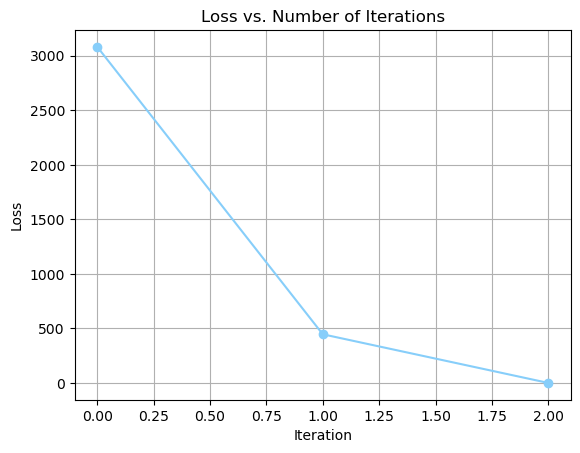

In [84]:
plt.plot(loss_list, marker='o', color = 'lightskyblue')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs. Number of Iterations")
plt.grid(True)
plt.show()

From the plot above, we can see that the loss function decreases monotonically until it eventually levels off near zero.